In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../BBTRE_physics_analysis/")

In [3]:
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [4]:
import matplotlib.ticker as ticker

In [5]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

In [6]:
runname = "run"
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/{runname}/"
budget_diags = ["budgetDiag", "tracer01Diag", "tracer02Diag", "tracer03Diag"]
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=budget_diags, delta_t=delta_t)
ds = ds.sel(time=ds['time'][0::2])
Lx = dx*ds["XC"].size
ds = periodic_extend(ds, ['XC', 'XG'], Lx, [-1,0])
xslice = [500, 500+800]
ds = ds.isel(XC=slice(*xslice), XG=slice(*xslice))
ds, grid = add_rotated_coords(ds, θ)
ds = ds.chunk({'XC': 400, 'XG': 400})
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

ds = ds.assign_coords({'days': (ds['time'].astype('float64')*1.e-9/86400.) - 5000.*(delta_t/60.)})

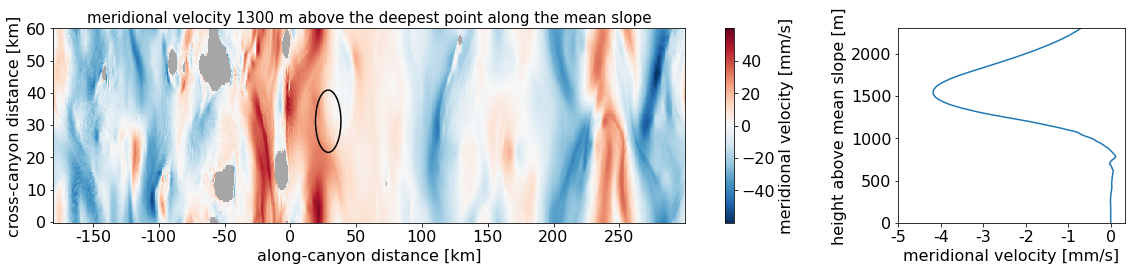

In [10]:
Lx, Ly = ds.XC.size*dx, ds.YC.size*dy

fig = plt.figure(figsize=(16,4))#, constrained_layout=True)
gs = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[0, 0:3])
PC = (ds['VVEL'].where(ds['VVEL']!=0.)*1e3).isel(time=0).isel(Z=30).plot(ax=ax1, cmap=div_cmap)
PC.colorbar.set_label(r"meridional velocity [mm/s]")
ds['TRAC01'].isel(time=0, Z=34).plot.contour(ax=ax1, colors="k", levels=[1e-2,np.nan])
plt.xlabel("along-canyon distance [km]")
plt.ylabel("cross-canyon distance [km]")
xticks = np.arange(-150, 300, 50)*1e3
plt.xticks(xticks, (xticks*1e-3).astype(np.int64))
yticks = np.arange(0, 70, 10)*1e3
plt.yticks(yticks, (yticks*1e-3).astype(np.int64))
plt.title("meridional velocity 1300 m above the deepest point along the mean slope", fontsize=15)

ax2 = fig.add_subplot(gs[0, 3])
((ds['VVEL'].isel(time=0)*ds['dyC']*ds['dxG']).sum(['XC', 'YG'])/(Lx*Ly)).plot(ax=ax2, y='Z')
plt.title("")
plt.xlabel(r"meridional velocity [mm/s]")
xticks = np.arange(-5, 1, 1)
plt.xticks(xticks*1e-3, xticks)
plt.ylabel("height above mean slope [m]")
plt.ylim(0, 2300)

plt.tight_layout()
plt.savefig("../../figures/BBTRE-tracer/S_meridional_flow.png", bbox_inches="tight", dpi=150., transparent=False)

In [11]:
moments = xr.open_dataset("../../data/BBTRE-tracer/tracer_moments.nc")

In [14]:
tmap = plt.get_cmap("Purples")
Nt = 440//2

# Analysis

In [15]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

In [16]:
for tr in [1,2,3]:
    ds[f'TRAC0{tr}'] = ds[f'TRAC0{tr}'].where(ds[f'TRAC0{tr}'] >= 0., 1.e-40)

In [20]:
TRAC_xy = []
TRAC_xz = []

TRAC_xy_init = []
TRAC_xz_init = []

for tr in range(1,4):
    tmp_xy_init = (ds[f'TRAC0{tr}']*ds['drF']).sum(dim='Z').isel(time=0)
    tmp_xy_init /= tmp_xy_init.max(dim=['XC', 'YC'])
    TRAC_xy_init.append(tmp_xy_init)
    
    tmp_xy = (ds[f'TRAC0{tr}']*ds['drF']).sum(dim='Z').sel(time=ds['time'][ds.days==440]).mean('time').compute()
    tmp_xy /= tmp_xy.max(dim=['XC', 'YC'])
    TRAC_xy.append(tmp_xy)

    tmp_xz_init = (ds[f'TRAC0{tr}']*ds['rA']).sum(dim='YC').isel(time=0)
    tmp_xz_init /= tmp_xz_init.max(dim=['XC', 'Z'])
    TRAC_xz_init.append(tmp_xz_init)
    
    tmp_xz = (ds[f'TRAC0{tr}']*ds['rA']).sum(dim='YC').sel(time=ds['time'][ds.days==440]).mean('time').compute()
    tmp_xz /= tmp_xz.max(dim=['XC', 'Z'])
    TRAC_xz.append(tmp_xz)

In [21]:
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C')

dz = 15.
hlevs = np.arange(0., 1500., dz)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


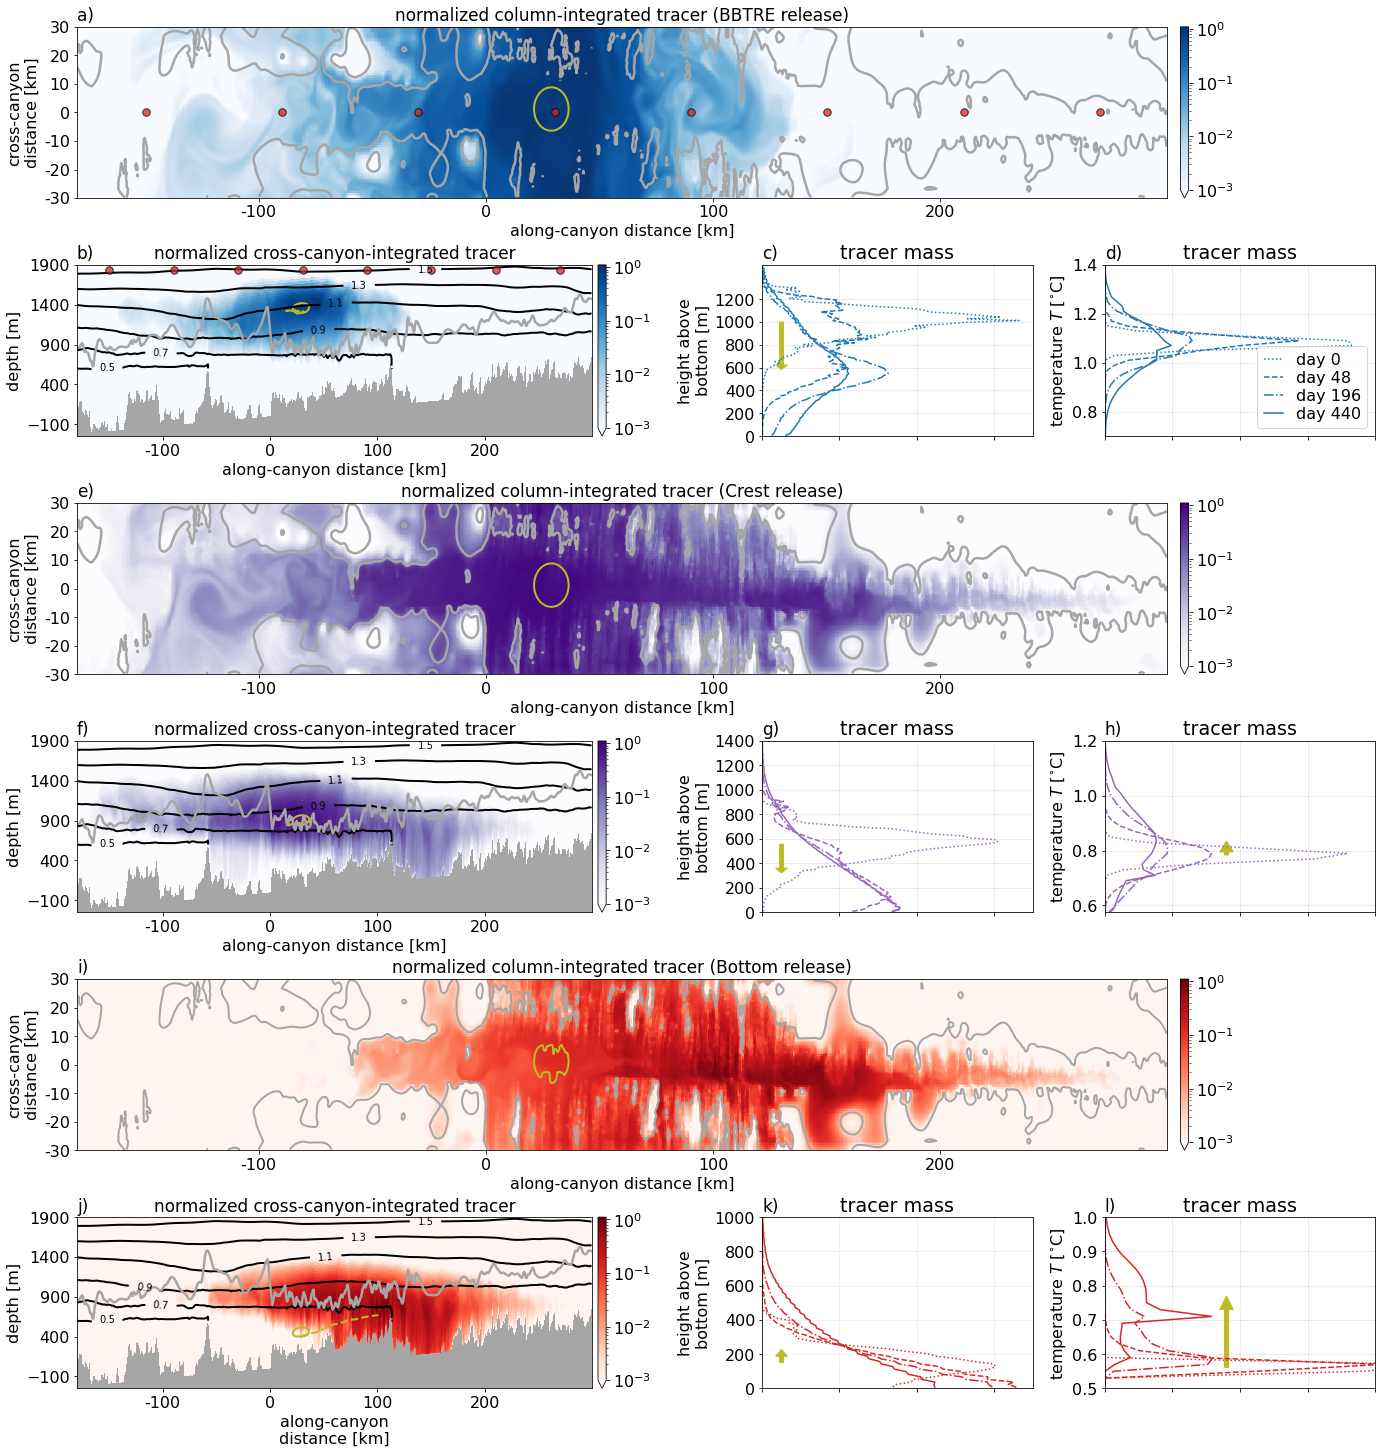

In [90]:
θlevels = np.arange(0.5, 2.5, 0.02)
θlevelsplot = np.arange(0.5, 2.5, 0.2)

ti = -1
xlims = [-1.8e5,3.e5]
ylims1 = [-250,1900]
ylims2 = [-250,1900]

θlw = 2.
blw = 2.5
tlw = 2.0

linestyle = [":", "--", "-.", "-"]
tis = np.int64((np.linspace(0, 21, 4)**2)//2)
tis[-1] = Nt
labels = tis*2

ylim = [[0.7, 1.4], [0.575, 1.2], [0.5, 1.0]]

fig = plt.figure(figsize=(19,20))#, constrained_layout=True)
gs = fig.add_gridspec(6, 4)

####
f_ax1 = fig.add_subplot(gs[0, :])
plt.title("a)", loc="left", fontsize=17)
cmaps = [
    None,
    matplotlib.cm.get_cmap("Blues"),
    matplotlib.cm.get_cmap("Purples"),
    matplotlib.cm.get_cmap("Reds")
]
tcolors=[None, "C0", "C4", "C3"]
tcolor = "C8"
θcolor = "k"
vmax = 1.1

q = TRAC_xy[0].plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[1])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
TRAC_xy_init[0].plot.contour(x='XC', y='YC', levels=[0.1, np.nan], colors=tcolor, linewidths=tlw)
(ds.H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = blw, levels=[1000, 1500])
plt.title("normalized column-integrated tracer (BBTRE release)", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon\ndistance [km]")
plt.xlim(xlims)

ids_tmp = ds.sel(YC=ds.YC[ds.YC.size//2]).sel(XC=ds.XC[50::100])
plt.plot(ids_tmp['XC'].values, np.ones_like(ids_tmp['XC'].values)*ids_tmp['YC'].values,
             ".", color="C3", markersize=15, markeredgecolor="k", markeredgewidth=1., alpha=0.75)

f_ax2 = fig.add_subplot(gs[1, :-2], facecolor=nancol)
plt.title("b)", loc="left", fontsize=17)
q = TRAC_xz[0].plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[1])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(moments['Xbar_Tr01'], moments['Zbar_Tr01'], "--", color=tcolor, lw=tlw)
(ds.H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
TRAC_xz_init[0].plot.contour(x='Xr', y='Zr', levels=[0.1, np.nan], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=θlevelsplot, linewidths=θlw)
f_ax2.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.title("normalized cross-canyon-integrated tracer", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")
plt.xlim(xlims)
plt.ylim(ylims2)

plt.plot(ids_tmp['XC'].values, np.ones_like(ids_tmp['XC'].values)*1835,
             ".", color="C3", markersize=15, markeredgecolor="k", markeredgewidth=1., alpha=0.75)

# HAB
f_ax4 = fig.add_subplot(gs[1, -2])
plt.title("c)", loc="left", fontsize=17)
TrMass = (ds["TRAC01"]*ds["dV"]).isel(time=tis)
histo = histogram(
    ds['Z_habC'].broadcast_like(TrMass),
    bins=[hlevs],
    weights=TrMass,
    dim=('XC', 'YC', 'Z',)
).load();
for i, ti in enumerate(tis):
    histo.isel(time=i).plot(y="Z_habC_bin", color=tcolors[1], linestyle=linestyle[i])
    plt.ylim(0, 1500)
    plt.yticks(np.arange(0., 1400., 200.))
    plt.ylabel("height above\nbottom [m]")
    plt.xlabel("")
    plt.xlim([0,3.5e8])
f_ax4.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.05e8; head_width = 0.15e8; head_length = 40;
plt.arrow(
    width*5, moments['HABbar_Tr01'].isel(time=0).values, 0, (moments['HABbar_Tr01'].isel(time=-1) - moments['HABbar_Tr01'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.xticks(labels=None)
plt.title("tracer mass")

# THETA
f_ax3 = fig.add_subplot(gs[1, -1])
plt.title("d)", loc="left", fontsize=17)
for i, ti in enumerate(tis):
    histo = histogram(
        ds['θ'].isel(time=ti),
        bins=[θlevels],
        weights=(ds[f'TRAC01']*ds['dV']).isel(time=ti)
    )
    histo.plot(y = "θ_bin", color=tcolors[1], linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[0])
    plt.ylabel(r"temperature $T$ [$^{\circ}$C]")
    plt.xlabel("")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.legend(handlelength=1.2, labelspacing=0.2)
f_ax3.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
plt.title("tracer mass")

#####
tr = 2
f_ax5 = fig.add_subplot(gs[2, :])
plt.title("e)", loc="left", fontsize=17)
q = TRAC_xy[tr-1].plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[tr])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
TRAC_xy_init[tr-1].plot.contour(x='XC', y='YC', levels=[0.1, np.nan], colors=tcolor, linewidths=tlw)
(ds.H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = blw, levels=[1000, 1500])
plt.title("normalized column-integrated tracer (Crest release)", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon\ndistance [km]")
plt.xlim(xlims)

f_ax6 = fig.add_subplot(gs[3, :-2], facecolor=nancol)
plt.title("f)", loc="left", fontsize=17)
q = TRAC_xz[tr-1].plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[tr])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(moments['Xbar_Tr02'], moments['Zbar_Tr02'], "--", color=tcolor, lw=tlw)
(ds.H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
TRAC_xz_init[tr-1].plot.contour(x='Xr', y='Zr', levels=[0.1, np.nan], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=θlevelsplot, linewidths=θlw)
f_ax6.clabel(CS, inline=1, fontsize=10)
plt.title("normalized cross-canyon-integrated tracer", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")
plt.xlim(xlims)
plt.ylim(ylims2)

# HAB
f_ax8 = fig.add_subplot(gs[3, -2])
plt.title("g)", loc="left", fontsize=17)
TrMass = (ds["TRAC02"]*ds["dV"]).isel(time=tis)
histo = histogram(
    ds['Z_habC'].broadcast_like(TrMass),
    bins=[hlevs],
    weights=TrMass,
    dim=('XC', 'YC', 'Z',)
).load();
for i, ti in enumerate(tis):
    histo.isel(time=i).plot(y="Z_habC_bin", color=tcolors[2], linestyle=linestyle[i])
    plt.ylim(0, 1200)
    plt.yticks(np.arange(0., 1600., 200.))
    plt.ylabel("height above\nbottom [m]")
    plt.xlabel("")
    plt.xlim([0,3.5e8])
plt.title("tracer mass")
f_ax8.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.05e8; head_width = 0.15e8; head_length = 40;
plt.arrow(
    width*5, moments['HABbar_Tr02'].isel(time=0).values, 0, (moments['HABbar_Tr02'].isel(time=-1) - moments['HABbar_Tr02'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.xticks(labels=None)

# THETA
f_ax7 = fig.add_subplot(gs[3, -1])
plt.title("h)", loc="left", fontsize=17)
for i, ti in enumerate(tis):
    histo = histogram(
        ds['θ'].isel(time=ti),
        bins=[θlevels],
        weights=(ds[f'TRAC02']*ds['dV']).isel(time=ti)
    )
    histo.plot(y = "θ_bin", color=tcolors[tr], linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[tr-1])
    plt.ylabel(r"temperature $T$ [$^{\circ}$C]")
    plt.xlabel("")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
f_ax7.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.03e9; head_width = 0.1e9; head_length = 0.04;
plt.arrow(
    width*30, moments['θbar_Tr02'].isel(time=0).values, 0, (moments['θbar_Tr02'].isel(time=-1) - moments['θbar_Tr02'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.title("tracer mass")

#####
tr = 3
f_ax9 = fig.add_subplot(gs[4, :])
plt.title("i)", loc="left", fontsize=17)
q = TRAC_xy[2].plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[3])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
TRAC_xy_init[2].plot.contour(x='XC', y='YC', levels=[0.1, np.nan], colors=tcolor, linewidths=tlw)
(ds.H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = 2., levels=[1000, 1500])
plt.title("normalized column-integrated tracer (Bottom release)", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon\ndistance [km]")
plt.xlim(xlims)

f_ax10 = fig.add_subplot(gs[5, :-2], facecolor=nancol)
plt.title("j)", loc="left", fontsize=17)
q = TRAC_xz[2].plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[3])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
(ds.H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
plt.ylim(0, 2500)
plt.plot(moments['Xbar_Tr03'], moments['Zbar_Tr03'], "--", color=tcolor, lw=tlw)
TRAC_xz_init[2].plot.contour(x='Xr', y='Zr', levels=[0.1, np.nan], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=θlevelsplot, linewidths=θlw)
f_ax10.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.title("normalized cross-canyon-integrated tracer", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon\ndistance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")
plt.xlim(xlims)
plt.ylim(ylims2)

## HAB
f_ax12 = fig.add_subplot(gs[5, -2])
plt.title("k)", loc="left", fontsize=17)
TrMass = (ds["TRAC03"]*ds["dV"]).isel(time=tis)
histo = histogram(
    ds['Z_habC'].broadcast_like(TrMass),
    bins=[hlevs],
    weights=TrMass,
    dim=('XC', 'YC', 'Z',)
).load();
for i, ti in enumerate(tis):
    histo.isel(time=i).plot(y="Z_habC_bin", color=tcolors[3], linestyle=linestyle[i])
    plt.yticks(np.arange(0., 1200., 200.))
    plt.ylim(0, 1000)
    plt.ylabel("height above\nbottom [m]")
    plt.xlabel("")
    plt.xlim([0,3.5e8])
plt.title("tracer mass")
f_ax12.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.2)
width = 0.05e8; head_width = 0.15e8; head_length = 40;
plt.arrow(
    width*5, moments['HABbar_Tr03'].isel(time=0).values, 0, (moments['HABbar_Tr03'].isel(time=-1) - moments['HABbar_Tr03'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.xticks(labels=None)

# Theta
f_ax11 = fig.add_subplot(gs[5, -1])
plt.title("l)", loc="left", fontsize=17)
for i, ti in enumerate(tis):
    histo = histogram(
        ds['θ'].isel(time=ti),
        bins=[θlevels],
        weights=(ds[f'TRAC03']*ds['dV']).isel(time=ti)
    )
    histo.plot(y = "θ_bin", color=tcolors[3], linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[tr-1])
    plt.ylabel(r"temperature $T$ [$^{\circ}$C]")
    plt.xlabel("")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.title("tracer mass")
f_ax11.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.03e9; head_width = 0.1e9; head_length = 0.04;
plt.arrow(
    width*30, moments['θbar_Tr03'].isel(time=0).values, 0, (moments['θbar_Tr03'].isel(time=-1) - moments['θbar_Tr03'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)

plt.tight_layout(pad=0, w_pad=0.75, h_pad=0.3)
plt.savefig("../../figures/BBTRE-tracer/tracer_spreading.png", dpi=100., bbox_inches="tight", transparent=False)

In [15]:
from wmt import *

for tr, tr_name in enumerate(["_TH"]):
    tmp = tracer_flux_budget(ds, grid, tr_name, θ=θ, Γ=Γ).chunk({'Z': -1, 'YC': -1, 'XC': 400})
    if tr_name[0] != "_":
        tr_name = "_"+tr_name
    tmp[f'total_tendency{tr_name}'] = tmp[f'conv_total_flux{tr_name}'].fillna(0.)
    tmp[f'diff_tendency{tr_name}'] = tmp[f'conv_horiz_diff_flux{tr_name}'] + tmp[f'conv_vert_diff_flux{tr_name}']
    tmp[f'adv_tendency{tr_name}'] = tmp[f'conv_horiz_adv_flux{tr_name}'] + tmp[f'conv_vert_adv_flux{tr_name}']
    if tr_name == "_TH":
        tmp[f'adv_tendency{tr_name}'] = tmp[f'adv_tendency{tr_name}'] + tmp['conv_adv_flux_anom_TH']
        tmp[f'diff_tendency{tr_name}'] = tmp[f'diff_tendency{tr_name}'] + tmp['conv_vert_diff_flux_anom_TH']
        tmp[f'total_tendency_truth{tr_name}'] = ds.TOTTTEND * ds['dV'] * day2seconds
    else:
        tmp[f'total_tendency_truth{tr_name}'] = ds[f'Tp_g{tr_name[1:]}'] * ds['dV'] * day2seconds
    ds = xr.merge([ds, tmp])

In [16]:
ds["ω"] = ds[f'diff_tendency_TH']/ds['dV']

In [20]:
ωθpdfs = {}

dθ = 0.02
θlevels = np.arange(0.4, 1.5, 0.02)
dθlevels = np.diff(θlevels)
abs_levels = 10**np.arange(-12, -6, 0.1)
ωlevels = np.concatenate((-abs_levels[::-1], [0.], abs_levels))
dωlevels = np.diff(ωlevels)

for tr in [1, 3]:
    ωθpdfs[tr] = {}
    for tt, ti in enumerate([50, 220], start=1):
        θbar = moments[f"θbar_Tr0{tr}"].isel(time=ti*2).values
        ωbar = moments[f"ωbar_Tr0{tr}"].isel(time=ti*2).values
        ωθpdfs[tr][ti] = histogram(
            ds['θ'].isel(time=ti),
            ds['ω'].isel(time=ti),
            bins=[θlevels, ωlevels],
            weights=((ds['ω']-ωbar)*(ds['θ']-θbar)*ds[f'TRAC0{tr}']*ds['dV']).isel(time=ti)
        ).compute()
        ωθpdfs[tr][ti] = ωθpdfs[tr][ti].assign_coords({
            "dθ_bin": xr.DataArray(dθlevels, coords=(ωθpdfs[tr][ti]["θ_bin"],)),
            "dω_bin": xr.DataArray(dωlevels, coords=(ωθpdfs[tr][ti]["ω_bin"],)),
        })
        ωθpdfs[tr][ti]["dωθ_bin"] = ωθpdfs[tr][ti]["dθ_bin"]*ωθpdfs[tr][ti]["dω_bin"]

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [21]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

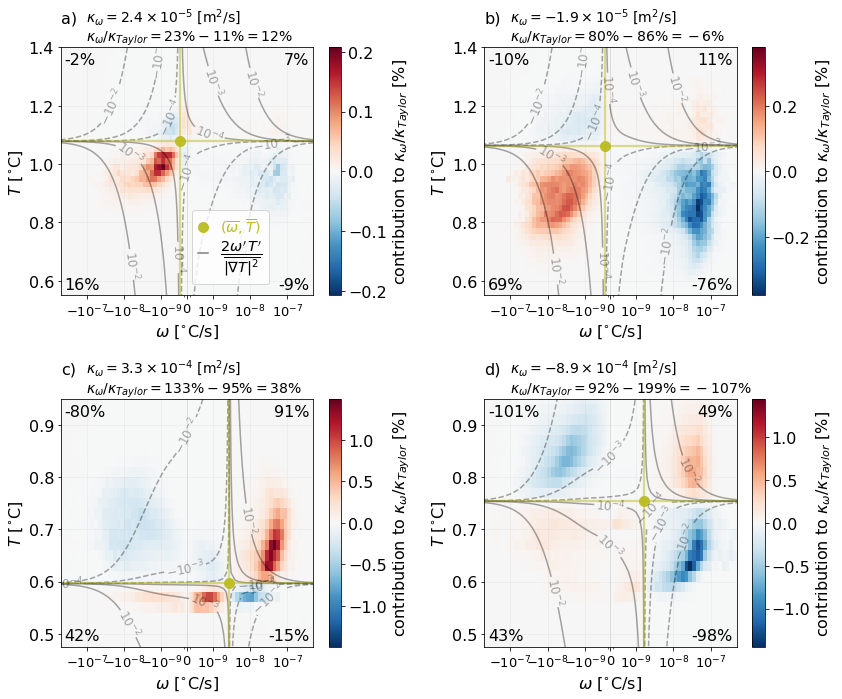

In [24]:
θ_lims = [
    [0.55, 1.4],
    [0.52, 1.05],
    [0.475, 0.95]
]

labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)"]

plt.figure(figsize=(12, 10))
for tri, tr in enumerate([1, 3], start=1):
    for tt, ti in enumerate([50, 220], start=1):
        
        θbar = moments[f"θbar_Tr0{tr}"].isel(time=ti*2).values
        ωbar = moments[f"ωbar_Tr0{tr}"].isel(time=ti*2).values
        Γsq = moments[f"Gradθ**2bar_Tr0{tr}"].isel(time=ti*2).values
        ωθlevels = 2*((θlevels[:, np.newaxis]-θbar)*(ωlevels[np.newaxis, :] - ωbar))/(Γsq)
        
        Δθ_lims = θ_lims[tr-1][1]-θ_lims[tr-1][0]
        κTgradT2 = moments[f"κGradθ**2bar_Tr0{tr}"].isel(time=ti*2).values
        M = moments[f"M_Tr0{tr}"].isel(time=ti*2).values
        quadrant1 = np.int64(np.round(2*ωθpdfs[tr][ti].where(np.logical_and((ωθpdfs[tr][ti]["θ_bin"]-θbar)>0., (ωθpdfs[tr][ti]["ω_bin"]-ωbar)<0)).sum()/M/κTgradT2*100).values)
        quadrant2 = np.int64(np.round(2*ωθpdfs[tr][ti].where(np.logical_and((ωθpdfs[tr][ti]["θ_bin"]-θbar)>0., (ωθpdfs[tr][ti]["ω_bin"]-ωbar)>0)).sum()/M/κTgradT2*100).values)
        quadrant3 = np.int64(np.round(2*ωθpdfs[tr][ti].where(np.logical_and((ωθpdfs[tr][ti]["θ_bin"]-θbar)<0., (ωθpdfs[tr][ti]["ω_bin"]-ωbar)<0)).sum()/M/κTgradT2*100).values)
        quadrant4 = np.int64(np.round(2*ωθpdfs[tr][ti].where(np.logical_and((ωθpdfs[tr][ti]["θ_bin"]-θbar)<0., (ωθpdfs[tr][ti]["ω_bin"]-ωbar)>0)).sum()/M/κTgradT2*100).values)
        
        pos_quadrants = quadrant2+quadrant3
        neg_quadrants = quadrant1+quadrant4
        tot_quadrants = pos_quadrants+neg_quadrants
        
        ax = plt.subplot(2, 2, tt+2*(tri-1))
        plt.axvline(0., color="k", alpha=0.075, lw=1.)
        ωθ_density = (ωθpdfs[tr][ti]/M)/κTgradT2*100.
        PC = ωθ_density.plot(cmap=div_cmap)
        PC.colorbar.set_label("contribution to $\kappa_{\omega}/\kappa_{Taylor}$ [%]")
        plt.xscale("symlog", linthresh=5e-10, linscale=0.35)
        plt.plot(moments[f"ωbar_Tr0{tr}"].isel(time=ti*2), moments[f"θbar_Tr0{tr}"].isel(time=ti*2), "C8o", markersize=10, alpha=0.95, label=r"$(\overline{\omega}, \overline{T})$")
        plt.axhline(θbar, color="C8", alpha=0.5, lw=2.25)
        plt.axvline(ωbar, color="C8", alpha=0.5, lw=2.25)
        plt.xlabel(r"$ω$ [$^{\circ}$C/s]")
        plt.xticks([-1e-7, -1e-8, -1e-9, 0, 1e-9, 1e-8, 1e-7], fontsize=13)
        plt.ylabel(r"$T$ [$^{\circ}$C]")
        plt.ylim(θ_lims[tr-1])
        ω_lims = [-5e-7, 5e-7]
        plt.xlim(ω_lims)
        plt.grid(True, alpha=0.15)
        CS = plt.contour(ωlevels[:], θlevels[:], ωθlevels, levels=[-1e-2, -1e-3, -1.e-4, 1e-4, 1e-3, 1e-2], colors="k", alpha=0.35)
        plt.plot([], [], "k-", alpha=0.5, label=r"$\dfrac{2 ω'\,T'}{\overline{|\nabla T|^{2}}}$")
        fmt = ticker.LogFormatterMathtext()
        fmt.create_dummy_axis()
        cb = plt.clabel(CS, inline=True, fontsize=12, fmt=fmt, rightside_up=True, inline_spacing=1)
        if (tr==1) & (tt==1):
            plt.legend(loc="lower left", fontsize=14.5, labelspacing=0.1, borderpad=0.45, labelcolor=["C8", "k"], handlelength=0.7, bbox_to_anchor=[0.49, 0.015, 0.51, 0.9])
        #if tr==1:
        #   plt.annotate(text=fr"$t = {{{ti*2}}}$ days", xy=(-0.9e-7, θ_lims[tr-1][1]-0.15), color="k", fontsize=14, bbox=dict(boxstyle="square,pad=0.15", fc="w", alpha=1.))
        κω = moments[f"κOmega_Tr0{tr}"].isel(time=ti*2).values
        κω_exp = np.int64(np.floor(np.log10(np.abs(κω))))
        κω_dec = np.round(κω*10.**(-κω_exp), 1)
        if κω>=0:
            titlecol = "C3"
        else:
            titlecol = "C0"

        plt.annotate(text=f"{quadrant1}%", xy=(ω_lims[0]+1e-7, θ_lims[tr-1][1]-0.02*Δθ_lims), horizontalalignment="left", verticalalignment="top", color="k")
        plt.annotate(text=f"{quadrant2}%", xy=(ω_lims[1]-1e-7, θ_lims[tr-1][1]-0.02*Δθ_lims), horizontalalignment="right", verticalalignment="top", color="k")
        plt.annotate(text=f"{quadrant3}%", xy=(ω_lims[0]+1e-7, θ_lims[tr-1][0]+0.015*Δθ_lims), horizontalalignment="left", verticalalignment="bottom", color="k")
        plt.annotate(text=f"{quadrant4}%", xy=(ω_lims[1]-1e-7, θ_lims[tr-1][0]+0.015*Δθ_lims), horizontalalignment="right", verticalalignment="bottom", color="k")
        
        title1 = fr"$\kappa_{{\omega}} = {{{κω_dec}}} \times 10^{{{{{κω_exp}}}}}$ [m$^{{2}}$/s]"
        title2 = fr"$\kappa_{{\omega}} / \kappa_{{Taylor}} = {pos_quadrants}\% - {-neg_quadrants}\% = {tot_quadrants}\%$"
        plt.title(title1+"\n"+title2, fontsize=14, color="k", loc="left", x=0.1)
        plt.text(0.0, 1.1, s=labels[tt-1+(tri-1)*2], transform=ax.transAxes)
        
plt.tight_layout()
plt.savefig("../../figures/BBTRE-tracer/diapycnal_stretching_pdfs.png", dpi=100., bbox_inches="tight", transparent=False)

In [25]:
c_pdfs = {}

for tr in [1, 3]:
    c_pdfs[tr] = {}
    for tt, ti in enumerate([50, 220], start=1):
        c_pdfs[tr][ti] = histogram(
            ds['θ'].isel(time=ti),
            ds['ω'].isel(time=ti),
            bins=[θlevels, ωlevels],
            weights=(ds[f'TRAC0{tr}']*ds['dV']).isel(time=ti)
        ).compute()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


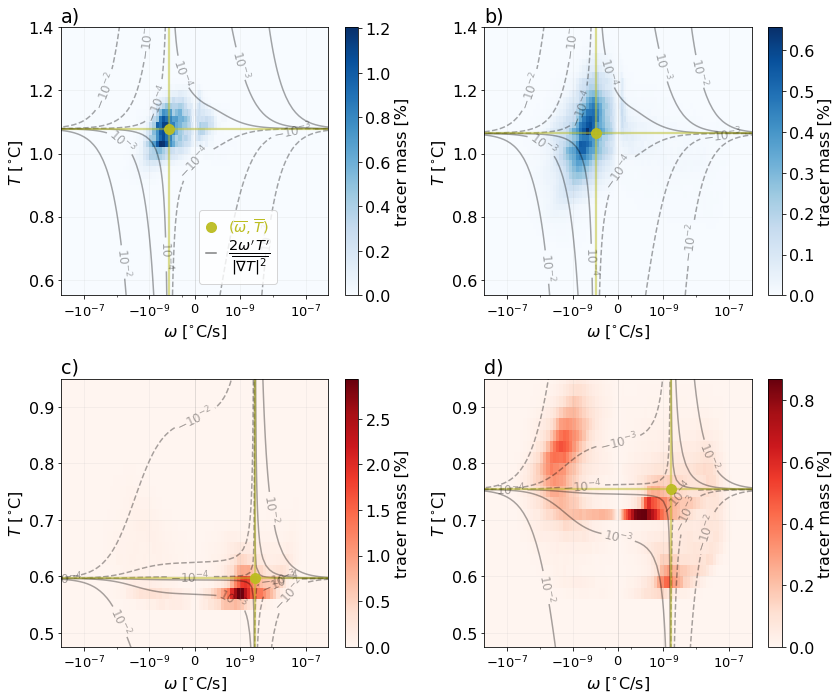

In [26]:

plt.figure(figsize=(12, 10))
for tri, tr in enumerate([1, 3], start=1):
    for tt, ti in enumerate([50, 220], start=1):
        
        θbar = moments[f"θbar_Tr0{tr}"].isel(time=ti*2).values
        ωbar = moments[f"ωbar_Tr0{tr}"].isel(time=ti*2).values
        Γsq = moments[f"Gradθ**2bar_Tr0{tr}"].isel(time=ti*2).values
        ωθlevels = 2*((θlevels[:, np.newaxis]-θbar)*(ωlevels[np.newaxis, :] - ωbar))/(Γsq)
        
        Δθ_lims = θ_lims[tr-1][1]-θ_lims[tr-1][0]
        κTgradT2 = moments[f"κGradθ**2bar_Tr0{tr}"].isel(time=ti*2).values
        M = moments[f"M_Tr0{tr}"].isel(time=ti*2).values
        
        ax = plt.subplot(2, 2, tt+2*(tri-1))
        plt.axvline(0., color="k", alpha=0.075, lw=1.)
        c_density = (c_pdfs[tr][ti]/M)*100.
        PC = c_density.plot(cmap=cmaps[tr])
        PC.colorbar.set_label("tracer mass [%]")
        plt.xscale("symlog", linthresh=1e-10, linscale=0.35)
        plt.plot(moments[f"ωbar_Tr0{tr}"].isel(time=ti*2), moments[f"θbar_Tr0{tr}"].isel(time=ti*2), "C8o", markersize=10, alpha=0.95, label=r"$(\overline{\omega}, \overline{T})$")
        plt.axhline(θbar, color="C8", alpha=0.5, lw=2.25)
        plt.axvline(ωbar, color="C8", alpha=0.5, lw=2.25)
        plt.xlabel(r"$ω$ [$^{\circ}$C/s]")
        plt.xticks([-1e-7, -1e-9, 0, 1e-9, 1e-7], fontsize=13)
        plt.ylabel(r"$T$ [$^{\circ}$C]")
        plt.ylim(θ_lims[tr-1])
        ω_lims = [-5e-7, 5e-7]
        plt.xlim(ω_lims)
        plt.grid(True, alpha=0.15)
        CS = plt.contour(ωlevels[:], θlevels[:], ωθlevels, levels=[-1e-2, -1e-3, -1.e-4, 1e-4, 1e-3, 1e-2], colors="k", alpha=0.35)
        plt.plot([], [], "k-", alpha=0.5, label=r"$\dfrac{2 ω'\,T'}{\overline{|\nabla T|^{2}}}$")
        fmt = ticker.LogFormatterMathtext()
        fmt.create_dummy_axis()
        cb = plt.clabel(CS, inline=True, fontsize=12, fmt=fmt, rightside_up=True, inline_spacing=1)
        if (tr==1) & (tt==1):
            plt.legend(loc="lower left", fontsize=14.5, labelspacing=0.1, borderpad=0.45, labelcolor=["C8", "k"], handlelength=0.7, bbox_to_anchor=[0.49, 0.015, 0.51, 0.9])
        
        plt.title(labels[tt-1+(tri-1)*2], loc="left")
        
plt.tight_layout()
plt.savefig("../../figures/BBTRE-tracer/tracer_mass_pdfs.png", dpi=100, bbox_inches="tight", transparent=False)

#### Buoyancy distribution

In [94]:
histo = histogram(
    ds['θ'].isel(time=220),
    bins=[θlevels],
    weights=(ds[f'TRAC01']*ds['dV']).isel(time=220)
).compute()

In [95]:
histo0 = histogram(
    ds['θ'].isel(time=0),
    bins=[θlevels],
    weights=(ds[f'TRAC01']*ds['dV']).isel(time=0)
).compute()

In [96]:
data = np.array([
    0.9838803329001582, 45.89211017847319,
    1.649127657809606, 45.898271960034215,
    1.4273785495064555, 46.012778918228385,
    0.7621312245970078, 46.02008213846198,
    1.4273785495064555, 45.895562233479296,
    2.5582990018525162, 45.901587390172004,
    2.778342347784106, 46.00900291260212,
    3.5561699892166896, 45.90644171314473,
    4.34116183260984, 46.00554525247321,
    5.019714104017476, 45.90883554644351,
    5.803227620021934, 46.00369626258868,
    6.469953272320071, 45.912470927182014,
    7.2682500622114095, 46.001643246234124,
    7.946802333619045, 45.91460277194543,
    9.011198053474162, 45.998485472914076,
    9.410346448419832, 45.916654629058684,
    10.474742168274949, 45.998015980184775,
    10.873890563220614, 45.91921075614044,
    11.938286283075731, 45.997459544357454,
    12.470484143003292, 45.92129739049289,
    13.401830397876518, 45.996903108530134,
    13.934028257804075, 45.92209726699467,
    15.397572372604861, 45.922723257300404,
    16.861116487405646, 45.923331858986536,
    17.765852849282496, 45.99250031004646,
    18.32466060220643, 45.92393466446613,
    19.300356678740286, 45.99190098229078,
    19.78820471700722, 45.9263922560368,
    20.839295490364144, 45.99123789626322,
    21.251748831808, 45.92752251631104,
    22.301361277776245, 45.99066832236776,
    22.715292946608784, 45.92853105624806,
    24.178837061409574, 45.92955698480469,
    25.293126330632894, 45.98947816795932,
    25.642381176210357, 45.93058291336131,
    26.70677689606547, 45.988904343512395,
    27.10592529101114, 45.93157406467873,
    28.18510428475313, 45.988288013550886,
    28.56946940581193, 45.93254782737654,
    29.64864839955392, 45.98771418910396,
    30.033013520612712, 45.93402586004286,
    31.097409240467833, 45.98616273782153,
    31.762656565377277, 45.93579949924244,
    33.22620068017806, 45.9361936412868,
    34.68974479497885, 45.93658778333115,
    34.82279425996074, 45.983166099043146,
    36.15328890977963, 45.936981925375505,
    36.28633837476152, 45.982835715270674,
    37.616833024580416, 45.937347086387184,
    37.74988248956231, 45.98236622254137,
    39.080377139381206, 45.93772963601847,
    40.54392125418199, 45.93802524255173,
    42.00746536898278, 45.9383556263242,
    43.47100948378356, 45.93866862147707,
    45.12082284955899, 45.9774278545739,
    46.54445212486521, 45.97700704997949,
    47.994691293167804, 45.97647148049569,
    49.3251859429867, 45.94237239745267,
    49.4449304614704, 45.975935911011895,
    50.78873005778749, 45.9429636105192,
    50.948389415765746, 45.97543859649123,
    52.25227417258827, 45.94346788048772,
    53.715818287389055, 45.94409387079345,
    53.995222163851025, 45.974329202560504,
    55.17936240218984, 45.94458075214236,
    55.36230541653994, 45.97384145178062,
    56.642906516990635, 45.94518935382849,
    56.86465562529378, 45.973283566901664,
    58.10645063179142, 45.9457110124166,
    58.416899383415824, 45.972752247969325,
    59.5699947465922, 45.946284836863526,
    59.23737108413748, 45.972359071959396,
    60.90048939641109, 45.96742360209519,
    61.033538861392984, 45.94684127269085,
    62.49708297619377, 45.947710703671035,
    64.75892388088589, 45.95209263581119,
    65.33547156247408, 45.96284846307055,
    66.22246799568667, 45.95287512369336,
    66.92763016009069, 45.961360770060004,
    67.68601211048747, 45.95348372537949,
    68.24777651818877, 45.96014936289428,
    69.20499350236403, 45.954140145769536,
    69.85915337185833, 45.9581090981941,
    70.94572400254376, 45.95740775720341
])
X, Y = data[::2], data[1::2]
ii = np.argsort(Y)
X, Y = X[ii], Y[ii]

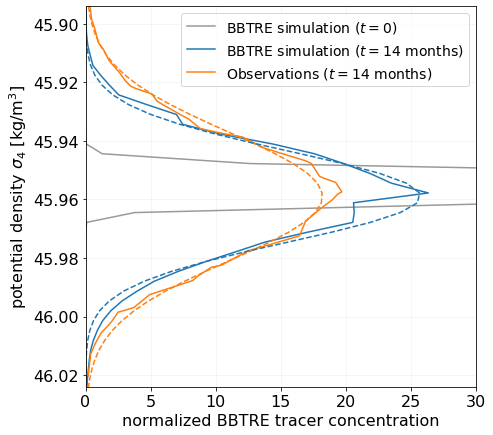

In [99]:
α_obs = 0.00016749649552323065
def T_to_ρ(T):
    return -ρ0*α_obs*T

plt.figure(figsize=(7,7))
histo0 = histo0.assign_coords({"ρ": T_to_ρ(histo0["θ_bin"])+46.137})
histo0 /= (-histo0*T_to_ρ(dθ)).sum()
histo0.plot(y="ρ", label=r"BBTRE simulation ($t=0$)", color="k", lw=1.5, alpha=0.4)

histo = histo.assign_coords({"ρ": T_to_ρ(histo["θ_bin"])+46.137})
histo /= (-histo*T_to_ρ(dθ)).sum()
histo.plot(y="ρ", label="BBTRE simulation ($t=$14 months)", lw=1.5, color="C0")

Xint = ((X[:-1]+X[0:-1])*0.5 * np.diff(Y)).sum()
X /= Xint
plt.plot(X, Y, "-", label=r"Observations ($t=$14 months)", lw=1.5, color="C1")

plt.ylim(46.04, 45.84)
plt.yticks(np.arange(46.04, 45.82, -0.02))
plt.grid(True, alpha=0.15)
plt.xticks()
plt.xlabel("normalized BBTRE tracer concentration")
plt.legend(fontsize=14)

σ = 0.031 / np.sqrt(2)
σ0 = 45.959
obs_scale = 2
plt.plot(np.exp(-(histo["ρ"].values-σ0)**2/(2*σ**2)) / np.sqrt(2*np.pi*σ**2), histo["ρ"].values, "C1--")
plt.plot(np.exp(-(histo["ρ"].values-σ0)**2/(2*σ**2/obs_scale)) / np.sqrt(2*np.pi*(σ**2/obs_scale)), histo["ρ"].values, "C0--")
plt.ylabel(r"potential density $\sigma_{4}$ [kg/m$^{3}$]")
plt.ylim(σ0+0.065, σ0-0.065)
plt.xlim(0, 30)
plt.savefig("../../figures/BBTRE-tracer/S_density_distribution_compare.png", bbox_inches="tight", dpi=100.)